In [23]:
#!wget https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/wetter.csv
#!wget https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/kiwo.csv
#!wget https://raw.githubusercontent.com/opencampus-sh/einfuehrung-in-data-science-und-ml/main/umsatzdaten_gekuerzt.csv

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

weather_df = pd.read_csv("wetter.csv")
kiwo_df = pd.read_csv("kiwo.csv")
sales_df = pd.read_csv("umsatzdaten_gekuerzt.csv")
holidays_df = pd.read_csv("../0_DataPreparation/holidays.csv")

print("Weather")
print(f" has {len(weather_df)} rows")
print(weather_df.head())
print("Kieler Woche")
print(f" has {len(kiwo_df)} rows")
print(kiwo_df.head())
print("Sales")
print(f" has {len(sales_df)} rows")
print(sales_df.head())
print("Holidays")
print(f" has {len(holidays_df)} rows")
print(holidays_df.head())

Weather
 has 2601 rows
        Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode
0  2012-01-01         8.0      9.8250                   14        58.0
1  2012-01-02         7.0      7.4375                   12         NaN
2  2012-01-03         8.0      5.5375                   18        63.0
3  2012-01-04         4.0      5.6875                   19        80.0
4  2012-01-05         6.0      5.3000                   23        80.0
Kieler Woche
 has 72 rows
        Datum  KielerWoche
0  2012-06-16            1
1  2012-06-17            1
2  2012-06-18            1
3  2012-06-19            1
4  2012-06-20            1
Sales
 has 9334 rows
        Datum  Warengruppe      Umsatz
0  2013-07-01            1  148.828353
1  2013-07-02            1  159.793757
2  2013-07-03            1  111.885594
3  2013-07-04            1  168.864941
4  2013-07-05            1  171.280754
Holidays
 has 486 rows
         date  summer  autumn  christmas  winter  easter  pentecoast
0  2013-06-24   

In [25]:
df = weather_df.merge(kiwo_df, on="Datum", how="left").merge(sales_df, on="Datum").merge(holidays_df, left_on="Datum", right_on="date", suffixes=("", "holiday_",))
df.fillna({"KielerWoche": 0, "holiday_sommer": 0, "holiday_autumn": 0, "holiday_christmas": 0, "holiday_winter": 0, "holiday_easter": 0, "holiday_pentecoast": 0}, inplace=True)
print(df.head())

        Datum  Bewoelkung  Temperatur  Windgeschwindigkeit  Wettercode  \
0  2013-07-01         6.0     17.8375                   15        20.0   
1  2013-07-01         6.0     17.8375                   15        20.0   
2  2013-07-01         6.0     17.8375                   15        20.0   
3  2013-07-01         6.0     17.8375                   15        20.0   
4  2013-07-01         6.0     17.8375                   15        20.0   

   KielerWoche  Warengruppe      Umsatz        date  summer  autumn  \
0          0.0            1  148.828353  2013-07-01       1       0   
1          0.0            2  535.856285  2013-07-01       1       0   
2          0.0            3  201.198426  2013-07-01       1       0   
3          0.0            4   65.890169  2013-07-01       1       0   
4          0.0            5  317.475875  2013-07-01       1       0   

   christmas  winter  easter  pentecoast  
0          0       0       0           0  
1          0       0       0           0  

In [26]:
# Features
#df["StartOfMonth"] = df[df["Datum_dt"].dt.day < 7]
df['Datum_dt'] = pd.to_datetime(df['Datum'])
df["StartOfMonth"] = np.where(df["Datum_dt"].dt.day < 7, 1, 0)


In [27]:
df.sample()

,Datum,Bewoelkung,Temperatur,Windgeschwindigkeit,Wettercode,KielerWoche,Warengruppe,Umsatz,date,summer,autumn,christmas,winter,easter,pentecoast,Datum_dt,StartOfMonth
1868,2017-10-17,7.0,14.725,13,NaN,0.0,5,243.654437,2017-10-17,0,1,0,0,0,0,2017-10-17,0


In [28]:
# Split (train and validation)

train_df = df[(df["Datum_dt"] >= "01.07.2013") & (df["Datum_dt"] <= "31.07.2017")]
validation_df = df[(df["Datum_dt"] >= "01.08.2017") & (df["Datum_dt"] <= "31.07.2018")]

print(f"Training Dataset length: {len(train_df)}")
print(f"Validation Dataset length: {len(validation_df)}")

Training Dataset length: 1694
Validation Dataset length: 605


In [29]:
import statsmodels.formula.api as smf

# Fit the linear model
mod = smf.ols('Umsatz ~ summer * autumn * StartOfMonth * C(Warengruppe)', data=df).fit()

# Print the summary
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                 Umsatz   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     188.1
Date:                Mon, 03 Jun 2024   Prob (F-statistic):               0.00
Time:                        15:57:09   Log-Likelihood:                -13018.
No. Observations:                2184   AIC:                         2.610e+04
Df Residuals:                    2151   BIC:                         2.629e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [30]:
predict_val = mod.predict(validation_df)

In [31]:
validation_df["Forecast"] = predict_val
validation_df["Diff"] = validation_df["Forecast"] - validation_df["Umsatz"]
print(validation_df["Diff"])

1579     -4.568278
1580     95.064370
1581     29.870318
1582     21.435912
1583    127.408876
           ...    
2179     24.887233
2180      9.381791
2181     -0.812479
2182     31.686108
2183     63.105255
Name: Diff, Length: 605, dtype: float64


/tmp/ipykernel_2092/1207021160.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df["Forecast"] = predict_val
/tmp/ipykernel_2092/1207021160.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df["Diff"] = validation_df["Forecast"] - validation_df["Umsatz"]


Text(0.5, 1.0, 'Comparison Actual Revenue vs. Forecast')

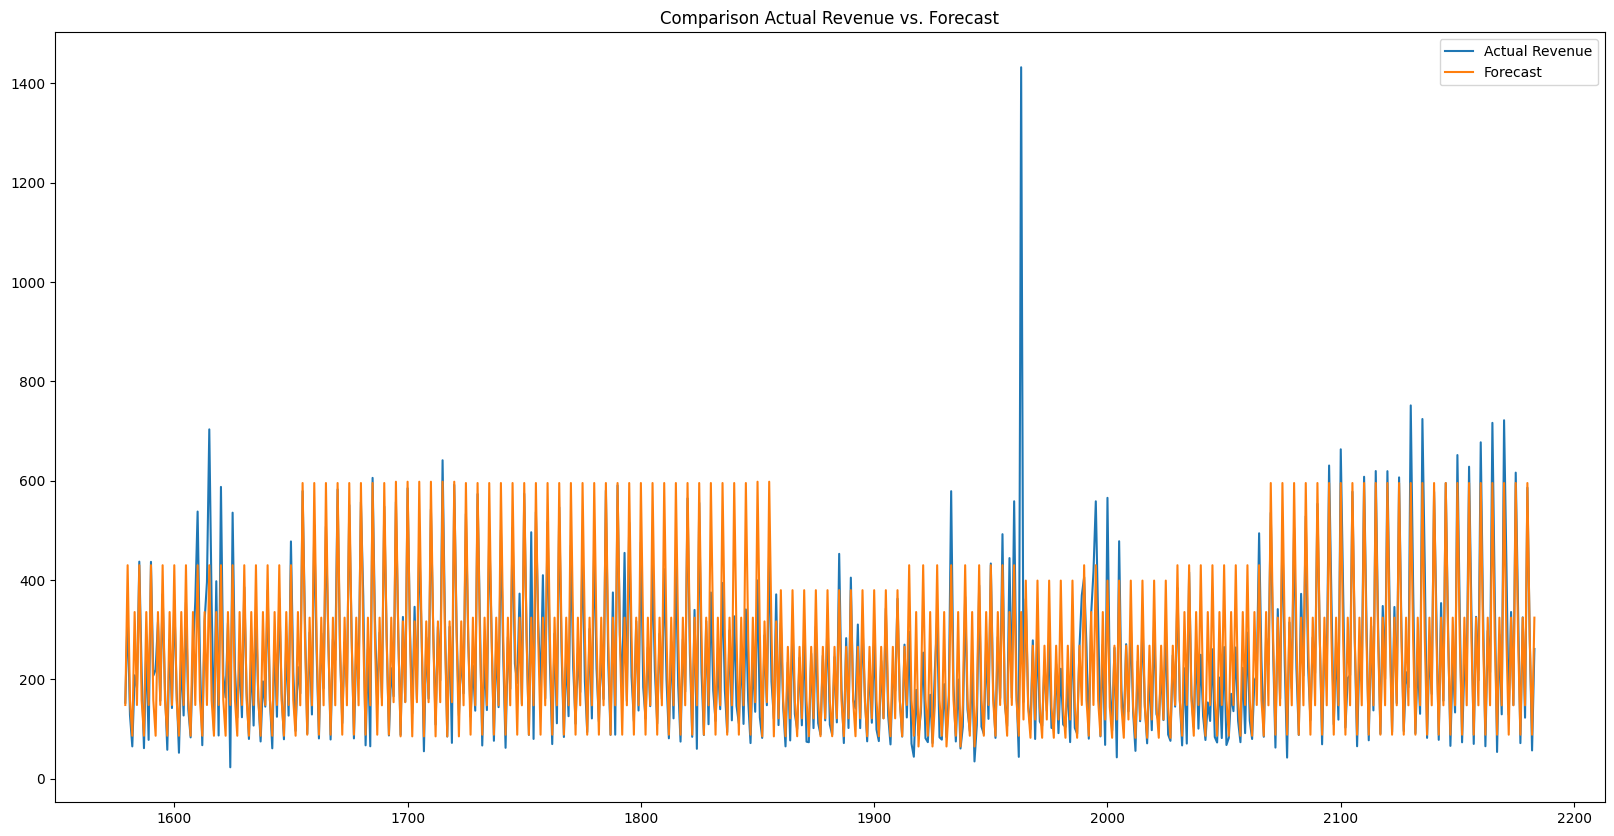

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.plot(validation_df.index, validation_df["Umsatz"], label="Actual Revenue")
ax.plot(validation_df.index, validation_df["Forecast"], label="Forecast")
ax.legend(loc="upper right")
ax.set_title("Comparison Actual Revenue vs. Forecast")